### Practice Notebook

Super Deadly dont touch

By Manu Patil and Katie Barno

# Question: How does negative media influence the fans of Justin Bieber? 
Assuming the fans of Bieber are, "infected," and using an SIR, or SBR, model to illustrate this phenomenon, how does negative media influence fans? We expect the negative media to operate as a negative contact rate. 



The following cells show our replication of the simulation in the Tweedle/Smith paper. We were able to produce a model that yeilded the same results as the paper. From here, we will expand the model to incorporate anti-fans, sweeps of the boredom rate, and a sweep of media coverage from extreme negative to extreme positive.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

   As in the SIR model, S and R in our model represent the suceptible and recovered populations. Our models B is the infected population typically represented as I. 
   
   $\epsilon$ : Our other parameters control the flows. Epsilon represents the total media that people consume, it is a proportion of positive and negative media. 
   
   $\pi$ : The 'recruitment rate' here reffers to the rate at which young people enter the system. It is not the rate at which people become fans.
   
   $\mu$ : The 'maturation rate' represents the rate at which people age out of our system. We are modeling individuals between the ages of five and seventeen years old.
   
   $\beta$ : The 'transmission rate' is the rate at which suceptible individuals become fans. 
   
   $b$ : Our 'boredom rate' is the rate of recovery from the bieber disease. This rate is not necesarily due to negative media, fans have just lost interest. 
   
   $P$ : The 'positive media rate' is the amount of positive media Bieber recieves per month.
   
   $N$ : The 'negative media rate' is the amount of negative media Bieber recieves per month.


In [2]:
def make_system(pi, Beta, mu, b ,P, N, epsilon, dt):
    """Make a system object for the SBR model.
    S: Susceptible
    B: Bieber-infected
    R: Recovered
    pi: Recruitment Rate
    Beta: Transmission Rate
    mu: Maturation Rate
    b: Boredom Rate
    P: Positive Media Rate
    N: Negative Media Rate
    epsilon: Positive Media Proportion
    
    returns: System object
    """
    init = State(S = 100, B = 3, R = 0);

    t0 = 0
    t_end = 10
    
    return System(init=init, t0=t0, t_end=t_end,
                  pi =pi, 
                  Beta = Beta, 
                  mu = mu,
                  b  = b,
                  P = P,
                  N = N, 
                  epsilon= epsilon,dt=dt)

In [48]:
def update_func_with_media(state, t, system):
    """Update the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*N
    boredom = b*B
    ds = entranceRate - infectedRate - posMediaPercent*S + negMediaPercent*B + posMediaPercent*R - negMediaPercent*S - mu*S
    db = infectedRate + posMediaPercent*S - negMediaPercent*B - boredom - mu*B # paper says R but should be B
    dr = boredom - posMediaPercent*R + negMediaPercent*S - mu*R
    S += ds* dt
    B += db*dt
    R += dr*dt

    return State(S = S, B = B, R = R);

In [49]:
def update_func_without_media(state, t, system):
    """Update the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*N
    boredom = b*B
    ds = entranceRate - infectedRate  - mu*S
    db = infectedRate - boredom - mu*B # paper says R but should be B
    dr = boredom- mu*R
    S += ds* dt
    B += db*dt
    R += dr*dt

    return State(S = S, B = B, R = R);

In [50]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

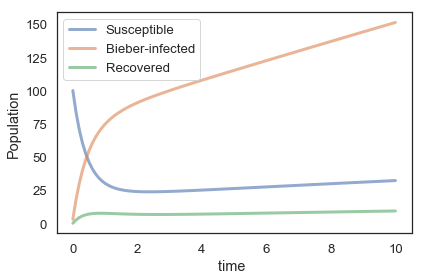

In [51]:
system = make_system(10, .00083, 1/144,1/24 , 2, 1, .75,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func_with_media);
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");

decorate(xlabel = "time ", ylabel = "Population");


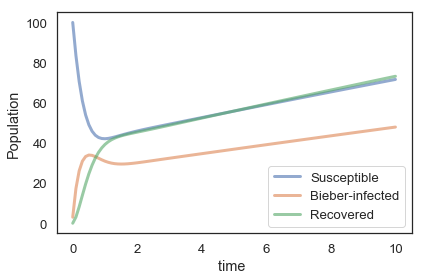

In [52]:
system = make_system(10, .00083, 1/144,2 , 2, 1, .75,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func_with_media);
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");

decorate(xlabel = "time ", ylabel = "Population");

# Change One: Introduction of anti-fans
 Due to his enourmous popularity, Justin Bieber has gathered a number of people who dislike him for no reason other than to rebel against what they percieve to be the mainstream. These "anti-fans" act almost as "infected" as our Bieber fans. The difference is, the anti-fan population is dependant on the fan population. We expect to see fewer anti-fans as the fan population decreases.

# OuR ModeL

In [85]:
def update_func_without_negmedia(state, t, system):
    """Update the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = 0
    negMediaPercent = (1-epsilon)*N
    boredom = b*B
    ds = entranceRate - infectedRate - posMediaPercent*S + negMediaPercent*B + posMediaPercent*R - negMediaPercent*S - mu*S
    db = infectedRate + posMediaPercent*S - negMediaPercent*B - boredom - mu*B # paper says R but should be B
    dr = boredom - posMediaPercent*R + negMediaPercent*S - mu*R
    S += ds* dt
    B += db*dt
    R += dr*dt

    return State(S = S, B = B, R = R);

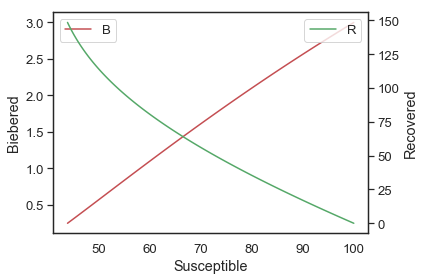

In [86]:
system = make_system(10, .00083, 1/144, 1/24 , 2, 1, .75,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func_without_negmedia);

#print(frame)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_yscale('linear')
ax1.plot(frame.S, frame.B, 'r')
ax1.set_ylabel("Biebered")
ax1.set_xlabel("Susceptible")
decorate();

ax2 = ax1.twinx()
# ax2 = ax1.twiny()
ax2.set_yscale(ax1.get_yscale())
ax2.plot(frame.S, frame.R, 'g')
ax2.set_ylabel('Recovered')
decorate();



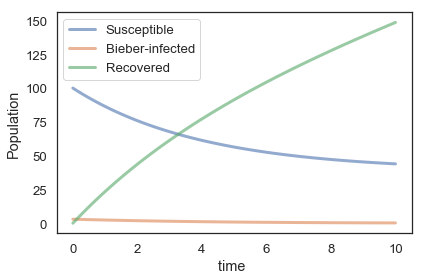

In [87]:
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");
decorate(xlabel = "time ", ylabel = "Population")

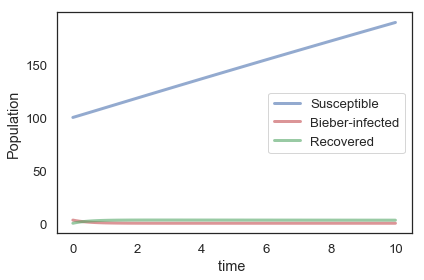

In [21]:
system = make_system(10, .00083, 1/144, 2, 2, 1, .75,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func_without_media);
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected",color = "r");
plot(frame.R, label = "Recovered",color= "g");

decorate(xlabel = "time ", ylabel = "Population");

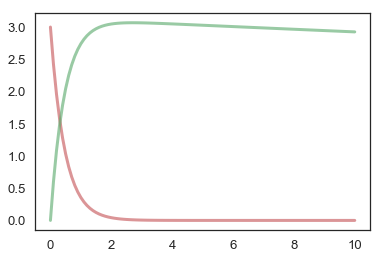

In [22]:
plot(frame.B, label = "Bieber-infected",color = "r");
plot(frame.R, label = "Recovered",color= "g");

In [98]:
def sweep_beta(pi, Beta, mu, b_array ,P, N, epsilon, dt):
    """Sweep a range of values for b.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
#     sweep[0] = 3
    for b in b_array:
        system = make_system(pi, Beta, mu, b ,P, N, epsilon, dt)
        frame = run_simulation(system, update_func_with_media) # Figure out what we actually want to measure here. Figure out which metric is best
        sweep[system.b] = calc_total_infected(frame.B, b_array)
        
    return sweep

In [99]:
def calc_total_infected(results, b_array):
    sum = 0
    
    for b in b_array:
        change = results[b] # - results[b-1] 
        sum += change
    return sum 

In [100]:
boredom_array = linrange(0,2,.01) 
frame1 = sweep_beta(10, .00083, 1/144, boredom_array, 2, 1, .75,1)


TypeError: cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [0.01] of <class 'numpy.float64'>

In [94]:
plot(frame1.B, label = "Bieber-infected",color = "r")

NameError: name 'frame1' is not defined

In [12]:
def sweep_beta(pi, Beta, mu, b_array ,P, N, epsilon, dt):
    """Sweep a range of values for b.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    sweep[0] = 3
    for b in b_array:
        system = make_system(pi, Beta, mu, b/10 ,P, N, epsilon, dt)
        frame = run_simulation(system, update_func_with_media) # Figure out what we actually want to measure here. Figure out which metric is best
        sweep[system.b] = calc_total_infected(frame.B)
        
    return sweep

In [13]:
def calc_total_infected(results):
    sum = 0
    ten = pd.Series([10])
    
    results2 = results
    results2.append(ten, ignore_index=True)
    
    print(results, results2)
    
    for b in boredom_array:
        change = results[b+1] - results2[b]
        sum += change
    return sum 

In [14]:
boredom_array = linrange(0,200,2) 
frame = sweep_beta(10, .00083, 1/144, boredom_array, 2, 1, .75,1)

0           3
1     151.728
2    -70.6188
3     343.102
4    -507.365
5     743.618
6    -2161.91
7    -2014.08
8    -1012.56
9     938.078
10   -4882.68
Name: B, dtype: object 0           3
1     151.728
2    -70.6188
3     343.102
4    -507.365
5     743.618
6    -2161.91
7    -2014.08
8    -1012.56
9     938.078
10   -4882.68
Name: B, dtype: object


KeyError: 11

In [15]:
plot(frame, label = "Bieber-infected",color = "r")

ValueError: modsimpy.plot can't handle DataFrames.

### ODE STUFFS

In [27]:
def slope_func(state, t, system):
    """Slope of the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*P
    boredom = b*B
    ds = entranceRate - infectedRate  - mu*S
    db = infectedRate - boredom - mu*B # paper says R but should be B
    dr = boredom- mu*R
  

    return ds,db,dr;

In [28]:
slope_func(init, 0, system)

(9.056555555555555, 0.10316666666666667, 0.125)

In [29]:
system = make_system(10, .00083, 1/144, 1/24, 2, 1, .75,1)
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,32
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


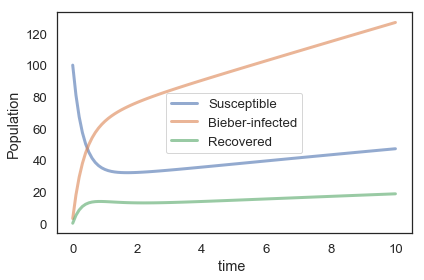

In [30]:
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");

decorate(xlabel = "time ", ylabel = "Population");